# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


# Libraries and datasets

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.dbscan import dbscan
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from col_names import *
from utility import *

from itertools import product

In [134]:
with open(f'{PICKLE_FOLDER}basket_prepared_df.pkl', 'rb') as f:
    b_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}item_prepared_df.pkl', 'rb') as f:
    i_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}user_prepared_df.pkl', 'rb') as f:
    u_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}shop_prepared_df.pkl', 'rb') as f:
    s_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}date_prepared_df.pkl', 'rb') as f:
    d_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}total_prepared_df.pkl', 'rb') as f:
    total_df = pickle.load(f)

In [135]:
with open(f'{PICKLE_FOLDER}pure_basket_prepared_df.pkl', 'rb') as f:
    pure_b_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_item_prepared_df.pkl', 'rb') as f:
    pure_i_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_user_prepared_df.pkl', 'rb') as f:
    pure_u_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_shop_prepared_df.pkl', 'rb') as f:
    pure_s_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_date_prepared_df.pkl', 'rb') as f:
    pure_d_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_prepared_df.pkl', 'rb') as f:
    pure_df = pickle.load(f)

## Outliers

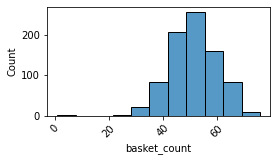

In [136]:
loghist(u_df, BCNT, '')

In [137]:
u_df[u_df[BCNT] < 20].index

Index([824], dtype='Int64', name='user_id')

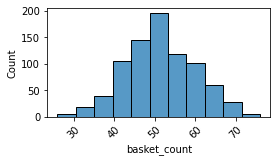

In [138]:
loghist(u_df.drop(u_df[u_df[BCNT] < 20].index), BCNT, '')

In [139]:
u_df = u_df.drop(u_df[u_df[BCNT] < 20].index)

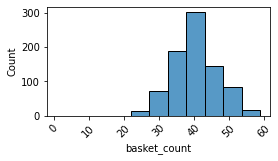

In [140]:
loghist(pure_u_df, BCNT, '')

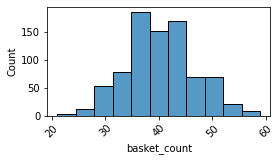

In [141]:
loghist(pure_u_df.drop(pure_u_df[pure_u_df[BCNT] < 20].index), BCNT, '')

In [142]:
pure_u_df = pure_u_df.drop(pure_u_df[pure_u_df[BCNT] < 20].index)

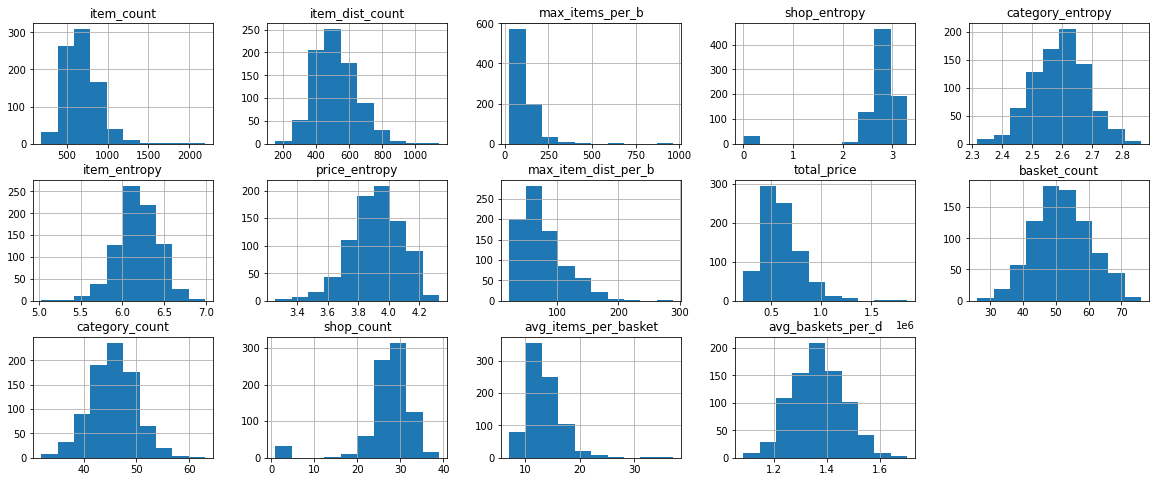

In [143]:
u_df.set_index(USER).hist(layout= (3, 5), figsize = (20, 8), bins = int(np.log2(len(u_df)) + 1))
plt.show()

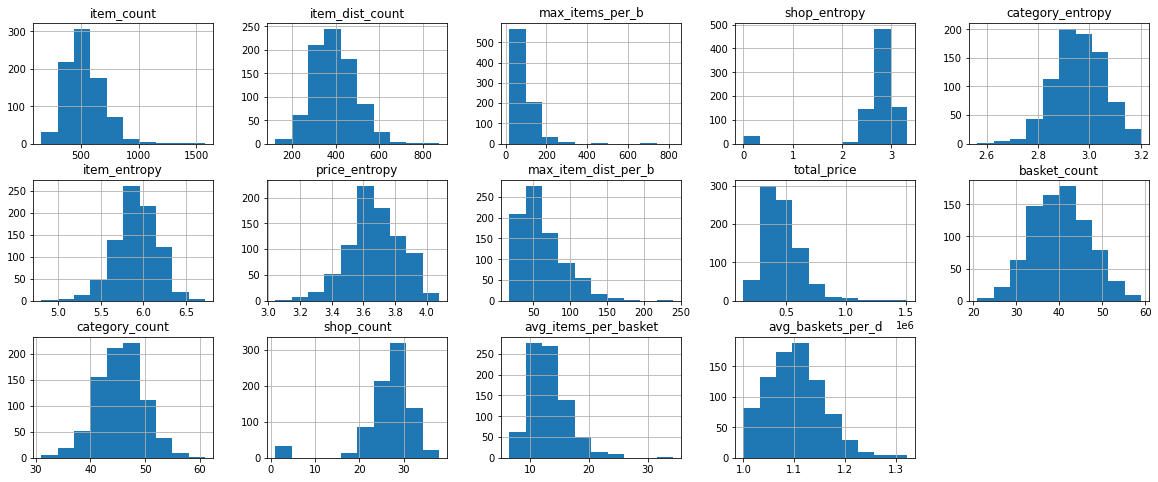

In [144]:
pure_u_df.set_index(USER).hist(layout= (3, 5), figsize = (20, 8), bins = int(np.log2(len(pure_u_df)) + 1))
plt.show()

## DBSCAN

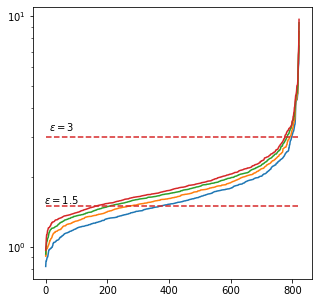

In [145]:
interesting = [823, 103, 313, 412, 162]
data = StandardScaler().fit_transform(u_df)
dist = squareform(pdist(data, 'euclidean'))
EMIN = 1.5
EMAX = 3
KMIN = 2
KMAX = 6
eps_range = [x / 10 for x in range(int(EMIN * 10), int(EMAX * 10))]
k_range = [x for x in range(KMIN, KMAX)]

plt.figure(figsize=(5, 5))
for k in k_range:
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances), label=f'k = {k}')
plt.hlines([EMIN, EMAX], xmin=0, xmax=data.shape[0], colors='tab:red', linestyles='--')
plt.text(50, EMIN+0.1, f'$\epsilon={EMIN}$', fontsize=10, va='center', ha='center')
plt.text(50, EMAX+0.3, f'$\epsilon={EMAX}$', fontsize=10, va='center', ha='center')

plt.yscale('log')
plt.show()

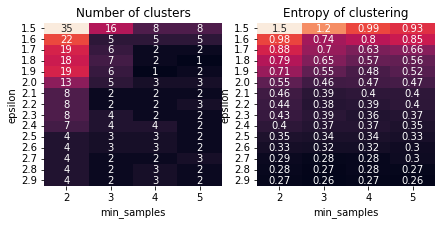

In [146]:
def entropy(v):
    relative_f = v.value_counts().values / len(v)
    return - np.sum(relative_f * np.log(relative_f))

def dbscan_evaluate(points, epsilon, k):
    dbscan_ins = DBSCAN(eps=epsilon, min_samples=k)
    dbscan_ins.fit(points)
    non_outlier_mask = dbscan_ins.labels_ >= 0
    n_clusters = len(np.unique(dbscan_ins.labels_[non_outlier_mask]))
    return n_clusters, entropy(pd.Series(dbscan_ins.labels_))

results_clusters = pd.DataFrame()
results_entropy = pd.DataFrame()

for epsilon, k in product(eps_range, k_range):
    n_clusters, _entropy = dbscan_evaluate(data, epsilon, k)
    results_clusters.loc[epsilon, k] = n_clusters
    results_entropy.loc[epsilon, k] = _entropy

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes = axes.ravel()
sns.heatmap(results_clusters, annot = True, ax=axes[0], cbar = False).set_title("Number of clusters")
axes[0].tick_params(labelrotation=0)
sns.heatmap(results_entropy, annot=True, ax=axes[1], cbar=False).set_title("Entropy of clustering")
axes[1].tick_params(labelrotation=0)

for ax in axes:
    ax.set_xlabel("min_samples")
    ax.set_ylabel("epsilon")
plt.show()

In [148]:
results_noise = pd.DataFrame()

for epsilon, k in product(eps_range, k_range):
    dbscan_ins = dbscan(data, epsilon, k)
    dbscan_ins.process()
    noise = dbscan_ins.get_noise()
    results_noise.loc[epsilon, k] = len(noise)

In [149]:
results_noise

,2,3,4,5
1.5,344.0,407.0,455.0,494.0
1.6,285.0,316.0,349.0,376.0
1.7,223.0,242.0,266.0,279.0
1.8,164.0,190.0,206.0,223.0
1.9,130.0,154.0,161.0,175.0
2.0,92.0,110.0,122.0,137.0
2.1,72.0,78.0,88.0,101.0
2.2,67.0,70.0,75.0,85.0
2.3,53.0,62.0,66.0,69.0
2.4,44.0,48.0,56.0,57.0


In [150]:
dbscan_ins = dbscan(data, 2.5, 3)
dbscan_ins.process()
noise = dbscan_ins.get_noise()
noise

[10,
 52,
 90,
 137,
 168,
 190,
 191,
 198,
 202,
 203,
 207,
 222,
 226,
 243,
 254,
 291,
 307,
 336,
 337,
 412,
 509,
 523,
 530,
 548,
 558,
 564,
 570,
 583,
 611,
 644,
 673,
 698,
 707,
 728,
 736,
 739,
 741,
 779,
 791,
 799]

In [151]:
u_df = u_df.drop(noise)


In [152]:
u_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 783 entries, 1 to 823
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               783 non-null    int64  
 1   item_count            783 non-null    int64  
 2   item_dist_count       783 non-null    int64  
 3   max_items_per_b       783 non-null    int64  
 4   shop_entropy          783 non-null    float64
 5   category_entropy      783 non-null    float64
 6   item_entropy          783 non-null    float64
 7   price_entropy         783 non-null    float64
 8   max_item_dist_per_b   783 non-null    int64  
 9   total_price           783 non-null    float64
 10  basket_count          783 non-null    int64  
 11  category_count        783 non-null    int64  
 12  shop_count            783 non-null    int64  
 13  avg_items_per_basket  783 non-null    float64
 14  avg_baskets_per_d     783 non-null    float64
dtypes: float64(7), int64(8)
memo

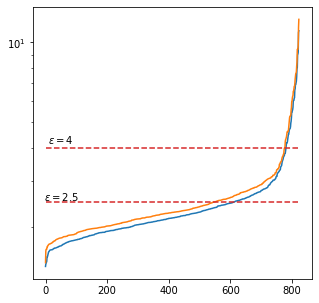

In [172]:
pure_data = StandardScaler().fit_transform(pure_u_df)
dist = squareform(pdist(pure_data, 'euclidean'))
EMIN = 2.5
EMAX = 4
KMIN = 2
KMAX = 4
eps_range = [x / 10 for x in range(int(EMIN * 10), int(EMAX * 10), 2)]
k_range = [x for x in range(KMIN, KMAX)]

plt.figure(figsize=(5, 5))
for k in k_range:
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances), label=f'k = {k}')
plt.hlines([EMIN, EMAX], xmin=0, xmax=data.shape[0], colors='tab:red', linestyles='--')
plt.text(50, EMIN+0.1, f'$\epsilon={EMIN}$', fontsize=10, va='center', ha='center')
plt.text(50, EMAX+0.3, f'$\epsilon={EMAX}$', fontsize=10, va='center', ha='center')

plt.yscale('log')
plt.show()

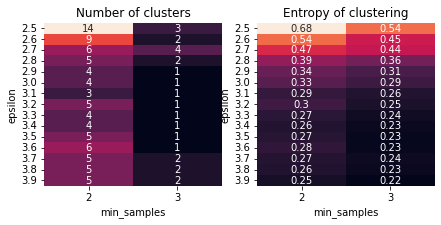

In [174]:
def entropy(v):
    relative_f = v.value_counts().values / len(v)
    return - np.sum(relative_f * np.log(relative_f))

def dbscan_evaluate(points, epsilon, k):
    dbscan_ins = DBSCAN(eps=epsilon, min_samples=k)
    dbscan_ins.fit(points)
    non_outlier_mask = dbscan_ins.labels_ >= 0
    n_clusters = len(np.unique(dbscan_ins.labels_[non_outlier_mask]))
    return n_clusters, entropy(pd.Series(dbscan_ins.labels_))

results_clusters = pd.DataFrame()
results_entropy = pd.DataFrame()

for epsilon, k in product(eps_range, k_range):
    n_clusters, _entropy = dbscan_evaluate(data, epsilon, k)
    results_clusters.loc[epsilon, k] = n_clusters
    results_entropy.loc[epsilon, k] = _entropy

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes = axes.ravel()
sns.heatmap(results_clusters, annot = True, ax=axes[0], cbar = False).set_title("Number of clusters")
axes[0].tick_params(labelrotation=0)
sns.heatmap(results_entropy, annot=True, ax=axes[1], cbar=False).set_title("Entropy of clustering")
axes[1].tick_params(labelrotation=0)

for ax in axes:
    ax.set_xlabel("min_samples")
    ax.set_ylabel("epsilon")
plt.show()

In [175]:
results_noise = pd.DataFrame()

for epsilon, k in product(eps_range, k_range):
    dbscan_ins = dbscan(pure_data, epsilon, k)
    dbscan_ins.process()
    noise = dbscan_ins.get_noise()
    results_noise.loc[epsilon, k] = len(noise)

In [176]:
results_noise

,2,3
2.5,156.0,166.0
2.6,126.0,135.0
2.7,99.0,117.0
2.8,83.0,89.0
2.9,77.0,81.0
3.0,71.0,73.0
3.1,61.0,63.0
3.2,58.0,59.0
3.3,54.0,55.0
3.4,51.0,52.0


In [177]:
dbscan_ins = dbscan(data, 3.8, 3)
dbscan_ins.process()
noise = dbscan_ins.get_noise()
noise

[10,
 52,
 101,
 103,
 107,
 162,
 186,
 190,
 191,
 198,
 202,
 203,
 207,
 221,
 243,
 256,
 276,
 281,
 307,
 313,
 393,
 412,
 416,
 424,
 523,
 530,
 548,
 558,
 564,
 570,
 629,
 643,
 644,
 696,
 698,
 720,
 739,
 746,
 771,
 779,
 785,
 799]

In [178]:
pure_u_df = pure_u_df.drop(noise)

In [179]:
pure_u_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 1 to 823
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           781 non-null    int64  
 1   item_count                        781 non-null    int64  
 2   item_dist_count                   781 non-null    int64  
 3   max_items_per_b                   781 non-null    int64  
 4   shop_entropy                      781 non-null    float64
 5   category_entropy                  781 non-null    float64
 6   item_entropy                      781 non-null    float64
 7   price_entropy                     781 non-null    float64
 8   max_item_dist_per_b               781 non-null    int64  
 9   total_price                       781 non-null    float64
 10  basket_count                      781 non-null    int64  
 11  category_count                    781 non-null    int64  
 12  shop_count   

## Shop rankings and feature selection

In [182]:
def ranking_and_elimination(user_df, shop_df, corr_threshold=0.85, figsize=(25,12)):
    # new shop rankings
    shop_df[NAPR] = rankings(shop_df[PAVG], 0).astype('int64')
    shop_df[NABR] = rankings(shop_df[BCNT], 0).astype('int64')
    shop_df[NAIR] = rankings(shop_df[ICNT], 0).astype('int64')
    shop_df[FAPR] = rankings(shop_df[PAVG], 1).astype('int64')
    shop_df[FABR] = rankings(shop_df[BCNT], 1).astype('int64')
    shop_df[FAIR] = rankings(shop_df[ICNT], 1).astype('int64')

    # new user rankings
    user_df[[NABR, NAIR, NAPR]] = total_df.merge(shop_df[[NABR, NAIR, NAPR]], on=SHOP, how='left').groupby(USER)[[NABR, NAIR, NAPR]].mean()
    pd.plotting.scatter_matrix(user_df[[NABR, NAIR, NAPR]], figsize=figsize)
    plt.show()

    user_df[[FABR, FAIR, FAPR]] = total_df.merge(shop_df[[FABR, FAIR, FAPR]], on=SHOP, how='left').groupby(USER)[[FABR, FAIR, FAPR]].mean()
    pd.plotting.scatter_matrix(user_df[[FABR, FAIR, FAPR]], figsize=figsize)
    plt.show()
    # scatter matrix with all variables
    # pd.plotting.scatter_matrix(user_df, figsize=corr_figsize)

    # pairwise correlation matrix among new variables
    _, axes = plt.subplots(1, 1, figsize=figsize)
    corr_new_matrix = user_df.set_index(USER)[[NABR, NAIR, NAPR, FABR, FAIR, FAPR]].corr()
    sns.heatmap(corr_new_matrix, annot=True, cmap="YlGnBu", ax=axes)
    plt.xticks(rotation=60)
    plt.show()

    # elimination of redundant features
    corr_matrix = user_df.set_index(USER).corr()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= corr_threshold)]
    print(f"Removed features: {to_drop}")
    func_df = user_df.drop(user_df[to_drop], axis=1)
    func_df = func_df.drop(USER, axis=1)
    return func_df

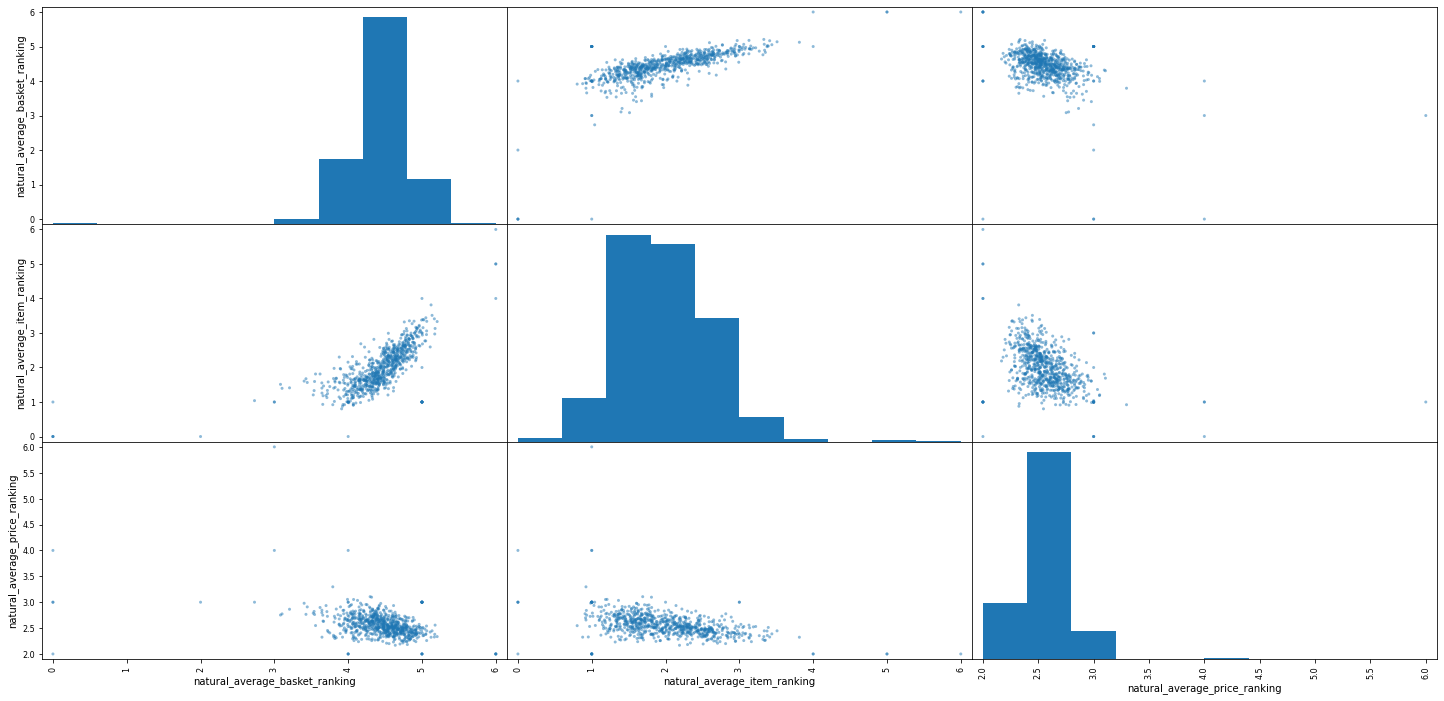

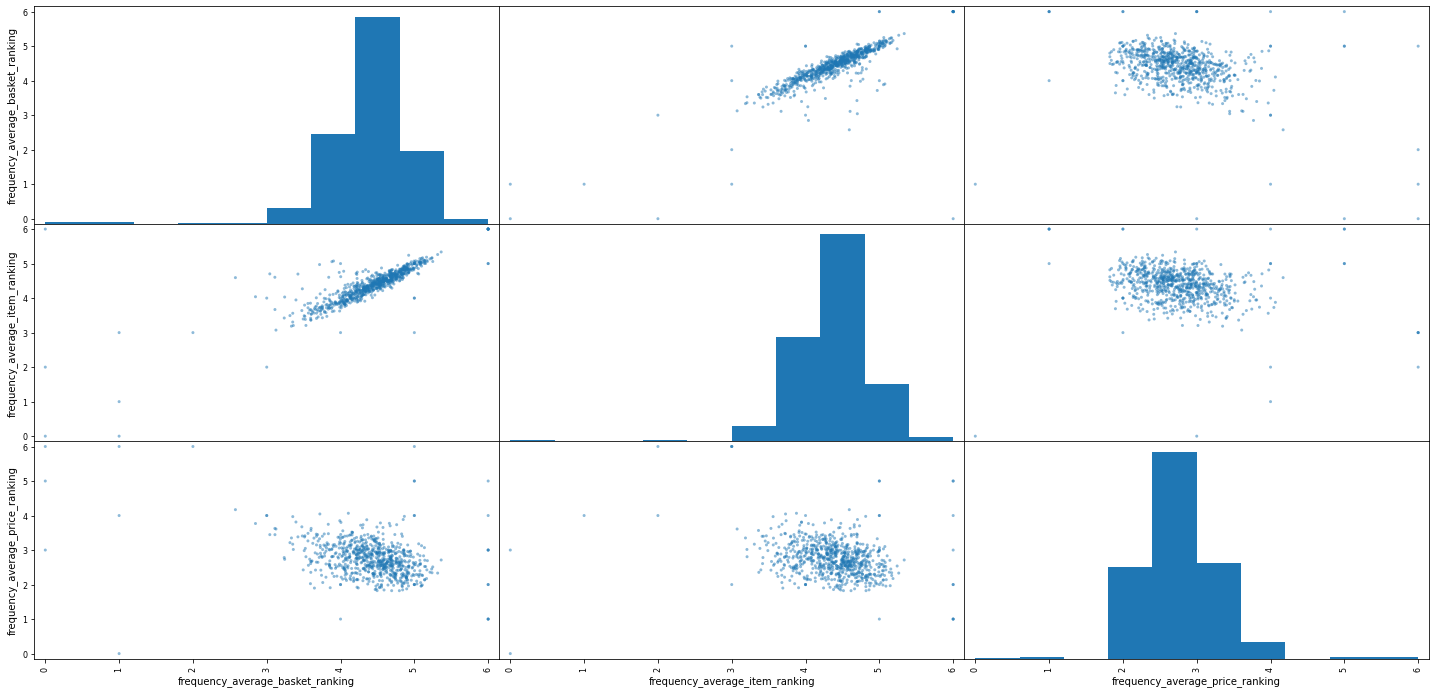

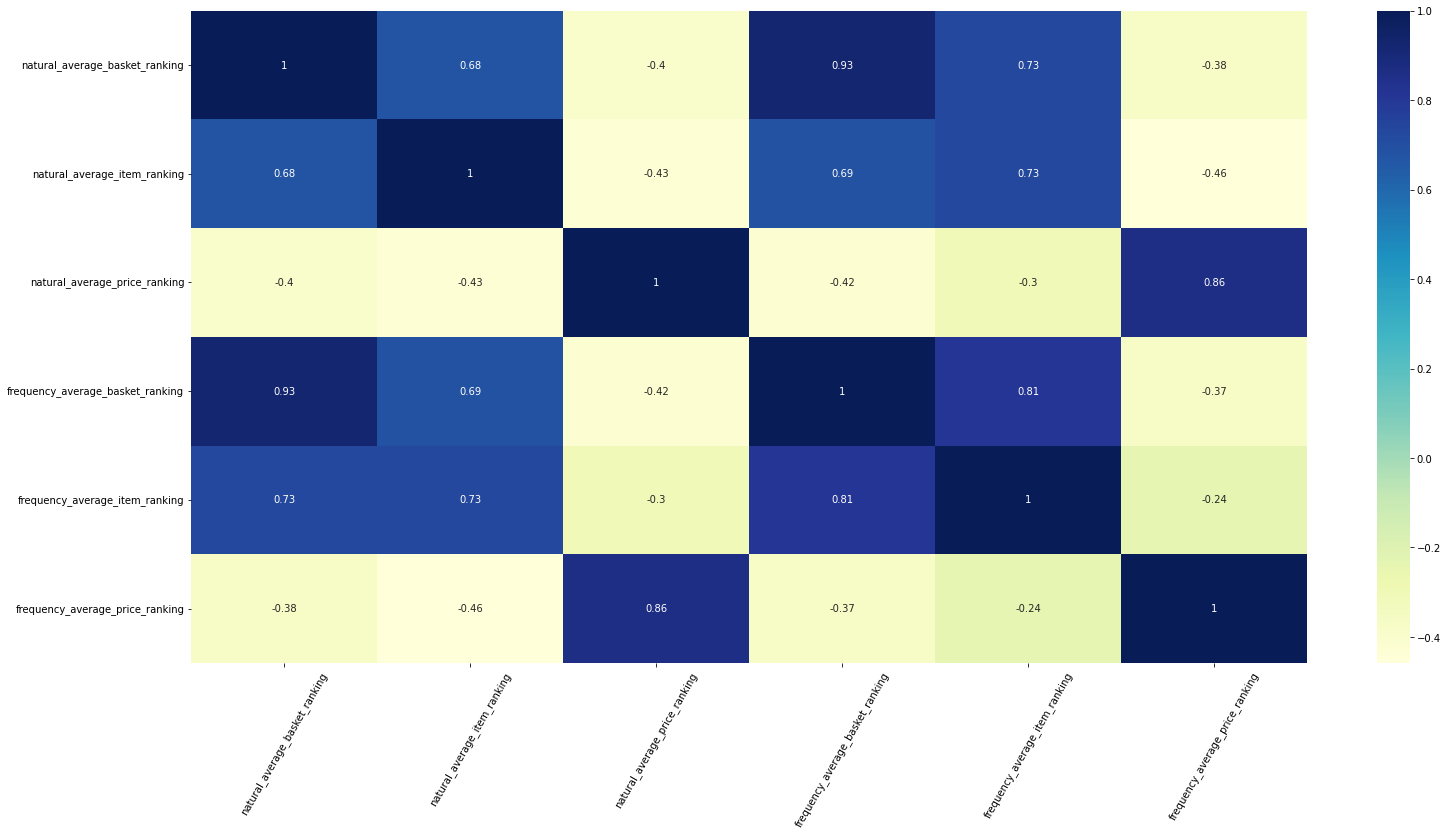

Removed features: ['item_dist_count', 'item_entropy', 'total_price', 'basket_count', 'shop_count', 'frequency_average_basket_ranking', 'frequency_average_price_ranking']


In [183]:
clustering_df = ranking_and_elimination(u_df, s_df)

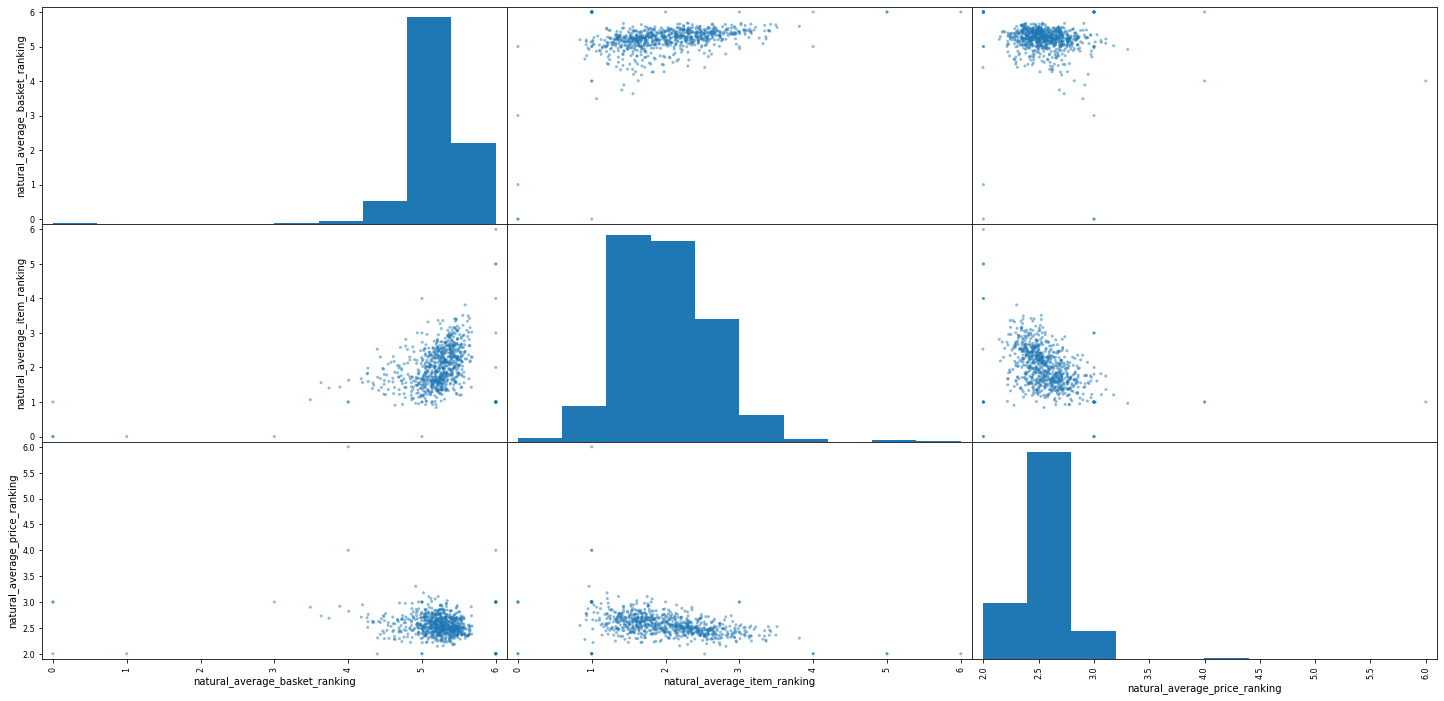

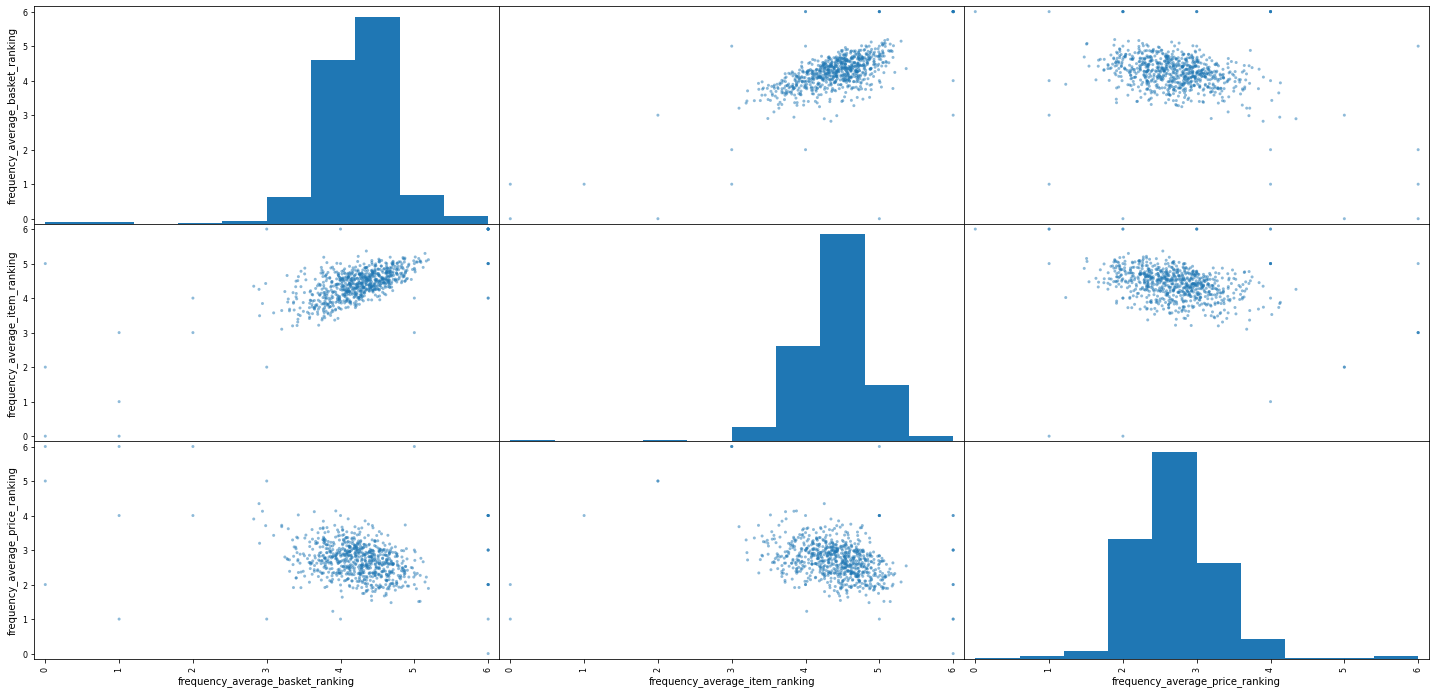

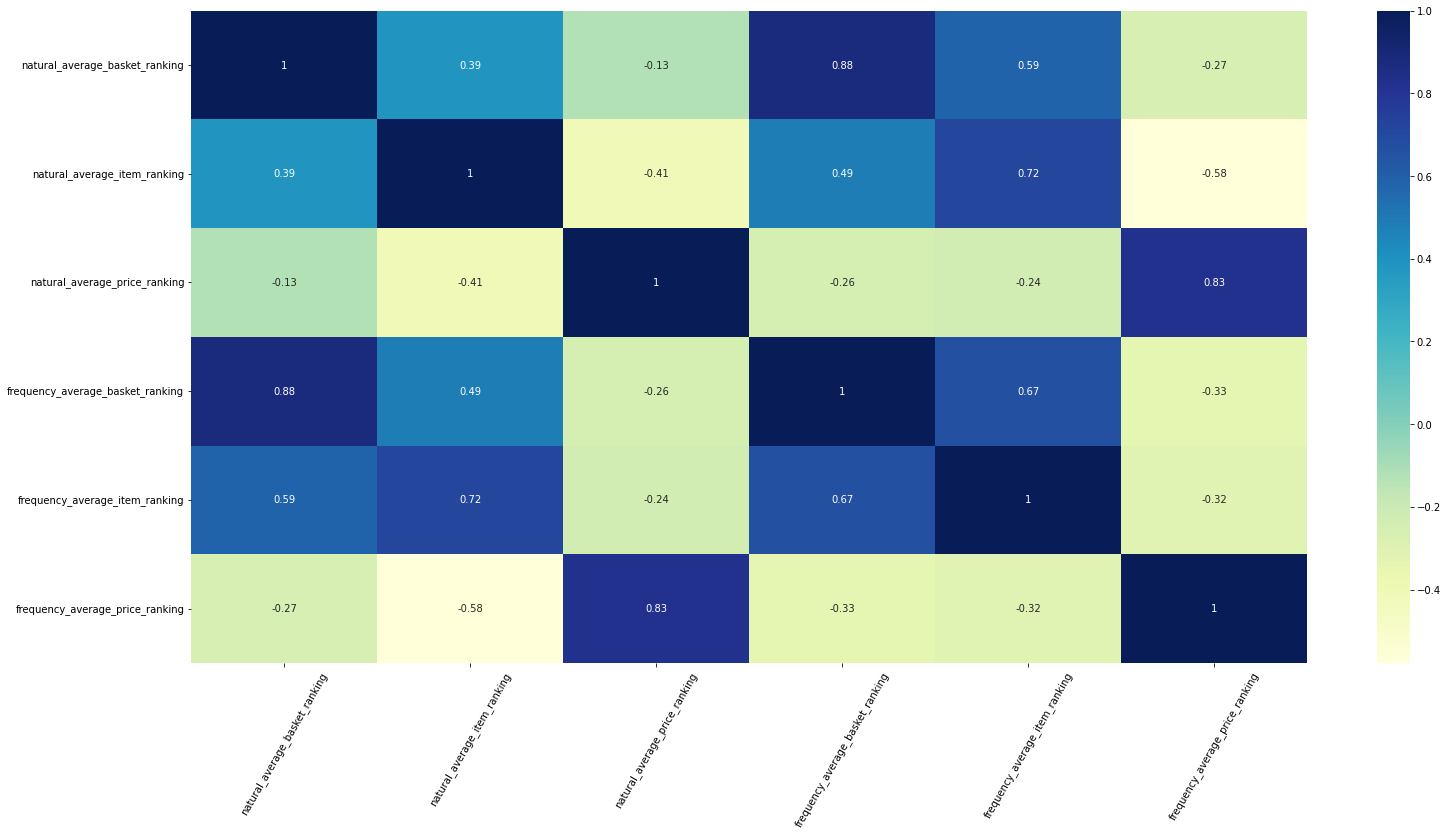

Removed features: ['item_dist_count', 'item_entropy', 'total_price', 'basket_count', 'shop_count', 'frequency_average_basket_ranking']


In [184]:
pure_clustering_df = ranking_and_elimination(pure_u_df, pure_s_df)

In [185]:
with open(f'{PICKLE_FOLDER}clustering_df.pkl', 'wb') as f:
    pickle.dump(clustering_df, f)

with open(f'{PICKLE_FOLDER}pure_clustering_df.pkl', 'wb') as f:
    pickle.dump(pure_clustering_df, f)

with open(f'{PICKLE_FOLDER}user_selected_df.pkl', 'wb') as f:
    pickle.dump(u_df, f)

with open(f'{PICKLE_FOLDER}pure_user_selected_df.pkl', 'wb') as f:
    pickle.dump(pure_u_df, f)